In [2]:
>>> import nltk
>>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import model_selection,metrics,preprocessing
import torch
from torchtext import data
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import spacy
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import RandomOverSampler

stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Model   ",torch.cuda.get_device_name(0))

GPU Model    Tesla P100-PCIE-16GB


In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [5]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=="Neutral":
            y.values[i]=0
        else:
            y.values[i]=1
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

In [6]:
with open("All_Tickers.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

X=X.sort_values("Date")

print("Number of Examples : ",len(X),"\n")
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n******************\n")

X['Target']=target_arrange(X['Target'])
X=X.drop('Date',1)

print("Neutral Examples : ",(X['Target']==0).sum())
print("Not Neutral Examples : ",(X['Target']==1).sum())


Number of Examples :  34125 

Number of Examples after removing duplicates:  33921 

Number of words before cleaning :  1305539
Number of words after cleaning :  878498

******************

Neutral Examples :  18194
Not Neutral Examples :  15727


In [7]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])
print(X['Article'])

Xv = X['Article'].to_frame()


0        krato present canaccord virtual growth confer ...
1        pyxi tanker announc date releas second quarter...
2        intellig system announc new board member norcr...
3        vianet group inc announc unaudit second quarte...
4        rewalk robot report second quarter financi res...
                               ...                        
33916    borg warner investig initi former louisiana at...
33917    bayer hour deadlin alert former louisiana atto...
33918    cantor fitzgerald bgc partner chariti day virt...
33919    chariti day virtual unstopp bgc partner cantor...
33920    halo lab provid oregon busi updat toronto busi...
Name: Article, Length: 33921, dtype: object


In [8]:
X_train,X_test,y_train,y_test = train_test_split(Xv,X['Target'], test_size=0.25,stratify=X['Target'])
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.2,stratify=y_train)

ros = RandomOverSampler(sampling_strategy=0.9)
X_train,y_train = ros.fit_resample(X_train, y_train)

train=pd.DataFrame(columns=['Article','Target'])
val = pd.DataFrame(columns=['Article','Target'])
test= pd.DataFrame(columns=['Article','Target'])


df = pd.DataFrame(data = X_train,columns=['Article'])
df1= pd.DataFrame(data = y_train,columns=['Target'])
train['Article']=df['Article']
train['Target']=df1['Target']
df = pd.DataFrame(data = X_test,columns=['Article'])
df1= pd.DataFrame(data = y_test,columns=['Target'])
test['Article']=df['Article']
test['Target']=df1['Target']
df = pd.DataFrame(data = X_val,columns=['Article'])
df1= pd.DataFrame(data = y_val,columns=['Target'])
val['Article']=df['Article']
val['Target']=df1['Target']

print("Neutral Examples in Training after OverSampling: ",(train['Target']==0).sum())
print("Not Neutral Examples in Training after OverSampling: ",(train['Target']==1).sum())

train.to_csv (r'General1.csv', index = False, header=True)
test.to_csv (r'General2.csv', index = False, header=True)
val.to_csv (r'General3.csv', index = False, header=True)


Neutral Examples in Training after OverSampling:  10916
Not Neutral Examples in Training after OverSampling:  9824


In [9]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

#TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
TEXT = data.Field(batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
X_train=data.TabularDataset(path = 'General1.csv',format = 'csv',fields = fields,skip_header = True)
X_test=data.TabularDataset(path = 'General2.csv',format = 'csv',fields = fields,skip_header = True)
X_val=data.TabularDataset(path = 'General3.csv',format = 'csv',fields = fields,skip_header = True)


TEXT.build_vocab(X_train)  
LABEL.build_vocab(X_train)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  




Size of TEXT vocabulary: 21628
Size of LABEL vocabulary: 2
[('stock', 8317), ('earn', 6546), ('inc', 6135), ('compani', 5936), ('announc', 5633), ('result', 4458), ('report', 3748), ('busi', 3609), ('new', 3547), ('investor', 3365)]


In [10]:
def find_accuracy(preds, y):
   
    temp = torch.round(preds)
    valid = (temp == y).float() 
    accur = valid.sum() / len(valid)
    return accur,temp,y

def Loss_Optimizer (model,valueLR):
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=valueLR)
    return optimizer,criterion

In [11]:
def train(model,data,lr,optimizer,criterion):
        
    model.train()
    sumloss=0.0
    sumacc=0.0
    for i in data:
        text, text_lengths = i.text   
        optimizer.zero_grad()
        pred = model(text, text_lengths).squeeze(1)       
        loss = criterion(pred, i.label)
        acc,dummy,dummy2 = find_accuracy(pred, i.label)
        loss.backward()
        optimizer.step()
        sumloss += loss.item()
        sumacc += acc.item()
          
    return sumloss / len(data), sumacc / len(data)

In [12]:
def test(model, data, criterion):
    y_pred_list = []
    y_true_list = []
    sumloss = 0
    sumacc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i in data:
            text, text_lengths = i.text
            
            pred = model(text, text_lengths).squeeze(1)
           
            loss = criterion(pred, i.label)
            
            acc,y_pred_tags,y_true = find_accuracy(pred, i.label)

            sumloss += loss.item()
            sumacc += acc.item()
            y_pred_list.append(y_pred_tags.cpu().numpy())
            y_true_list.append(y_true.cpu().numpy())
        
    return sumloss / len(data), sumacc / len(data),y_pred_list,y_true_list

In [13]:
def process_test(model,numEpochs,data_tr,data_val,data_test,lr,loss_file,acc_file,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    fileout=open(loss_file,"w")
    fileout2=open(acc_file,"w")
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,dummy,dummy2 = test(model, data_val, criterion)
        fileout.write(str(valid_loss)+"\n")
        fileout2.write(str(valid_acc)+"\n")
        if i==0:
            max=valid_acc
            torch.save(model.state_dict(), best_model)
        elif valid_acc > max:
            max = valid_acc
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    fileout.close()
    fileout2.close()  
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list = test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')
    

In [14]:
def process_test2(model,numEpochs,data_tr,data_val,data_test,lr,loss_file,acc_file,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    fileout=open(loss_file,"w")
    fileout2=open(acc_file,"w")
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,dummy,dummy2 = test(model, data_val, criterion)
        fileout.write(str(valid_loss)+"\n")
        fileout2.write(str(valid_acc)+"\n")
        if i==0:
            minloss=valid_loss
            torch.save(model.state_dict(), best_model)
        elif valid_loss < minloss:
            minloss = valid_loss
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    fileout.close()
    fileout2.close()  
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list = test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')

In [15]:
print("GPU Model   ",torch.cuda.get_device_name(0))

GPU Model    Tesla P100-PCIE-16GB


In [16]:
class myLSTM(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.LSTM(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text, text_lengths):
                
        embedded = self.dropout(self.embedding(input_text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        rnn_out,(rnn_hid,rnn_cell) = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((rnn_hid[-2,:,:], rnn_hid[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return F.sigmoid(out)

In [17]:
class myGRU(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.GRU(embed_d,hid_d,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text,text_lengths):
                
        embedded = self.dropout(self.embedding(input_text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        rnn_out,hidden = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return F.sigmoid(out)

In [18]:
myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 1
batch=1024
train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)  
dropout = 0.3

new_model2 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model2.to(torch.device(device))
new_model3 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model3.to(torch.device(device))

print(new_model2)
print(new_model3)
#torch.save(new_model2.state_dict(), 'model_LSTM_1.pt')

myLSTM(
  (embedding): Embedding(21628, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
myGRU(
  (embedding): Embedding(21628, 300)
  (rnn): GRU(300, 256, num_layers=2, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


Epoch :  5  Train Loss :  0.24562312108242795   Train Acc :  0.8898809523809523   Valid Loss :  0.3080747276544571  Val Acc :  0.8644594192504883
Epoch :  10  Train Loss :  0.100096498424786   Train Acc :  0.9604724702380952   Valid Loss :  0.42255963683128356  Val Acc :  0.8661731243133545
Epoch :  15  Train Loss :  0.03824930118086437   Train Acc :  0.9856770833333334   Valid Loss :  0.5956168353557587  Val Acc :  0.8660093188285828
Epoch :  20  Train Loss :  0.020811549949853327   Train Acc :  0.9926060267857143   Valid Loss :  0.7055203735828399  Val Acc :  0.8605279684066772
Epoch :  25  Train Loss :  0.0142272282342414   Train Acc :  0.9952101934523809   Valid Loss :  0.9845600247383117  Val Acc :  0.8642452001571655
Epoch :  30  Train Loss :  0.016005154848071038   Train Acc :  0.9944196428571429   Valid Loss :  1.0840083181858062  Val Acc :  0.8655808925628662
Epoch :  35  Train Loss :  0.00911457421136133   Train Acc :  0.9972098214285714   Valid Loss :  1.1404455423355102  Va

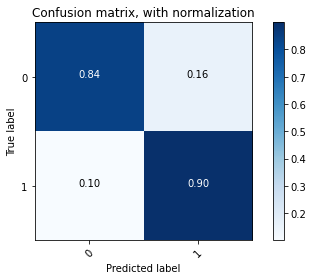

In [19]:
process_test(new_model2,40,train_it,val_it,test_it,0.001,"lstm1_loss.txt","lstm1_acc.txt","LSTM_Tech_NeutnotNeut_model.pt")

Epoch :  5  Train Loss :  0.23464203577133871   Train Acc :  0.8971354166666666   Valid Loss :  0.32607778906822205  Val Acc :  0.8550340175628662
Epoch :  10  Train Loss :  0.11479379143704482   Train Acc :  0.9555431547619048   Valid Loss :  0.4101711630821228  Val Acc :  0.8746534705162048
Epoch :  15  Train Loss :  0.05395063573849343   Train Acc :  0.9800502232142857   Valid Loss :  0.5411662518978119  Val Acc :  0.8675907254219055
Epoch :  20  Train Loss :  0.027531544670983704   Train Acc :  0.9907924107142857   Valid Loss :  0.6515701055526734  Val Acc :  0.86755291223526
Epoch :  25  Train Loss :  0.020038058231529293   Train Acc :  0.9927920386904762   Valid Loss :  0.7943174839019775  Val Acc :  0.8658392071723938
Epoch :  30  Train Loss :  0.014758749604446902   Train Acc :  0.9954892113095238   Valid Loss :  0.9776990294456482  Val Acc :  0.8675844192504882
Epoch :  35  Train Loss :  0.012097393095679027   Train Acc :  0.9956287202380952   Valid Loss :  1.0509837031364442 

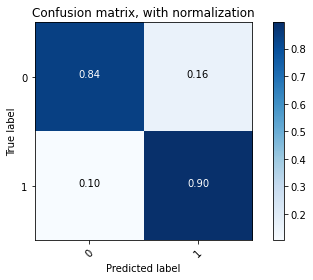

In [20]:
process_test(new_model3,40,train_it,val_it,test_it,0.001,"gru1_loss.txt","gru1_acc.txt","GRU_Tech_NeutnotNeut_model.pt")